# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

# Load Data

In [4]:
%%time

map_data_folder = Path(".").resolve()
print(f"Loading from: {map_data_folder}")
all_frames = [pd.read_pickle(f) for f in map_data_folder.glob("*.pkl")]
all_data = pd.concat(all_frames)
print(f"Loaded {len(all_frames)} dataframes for total size = {all_data.shape}")

Loaded 10 dataframes for total size = (36000000, 2)
CPU times: user 24.2 s, sys: 4.28 s, total: 28.5 s
Wall time: 28.8 s


# Utility Functions

In [5]:
def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")

# Performance Curves

For the subsequent plots, we only want to evaluate on classes seen so far, so let's insert NaN values in places where the class had not yet been trained on.

In [6]:
# Nix all rows where classes_trained <= class_id.
classes_seen_perf = all_data.copy()
unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <= 
               classes_seen_perf.index.get_level_values("class_id"))
classes_seen_perf[unseen_rows] = np.nan

First, performance for each learning rate separately.

In [7]:
%%time

# For each training configuration, get a series of average performance per classes trained.
# First, we want to average over all classes to get overall performance numbers.
groupby_labels = ["model", "dataset", "num_train_examples", "num_test_examples", "lr", "classes_trained", "trial"]
over_all_classes = classes_seen_perf.groupby(groupby_labels).mean()

CPU times: user 10.3 s, sys: 3.04 s, total: 13.4 s
Wall time: 13.4 s


CPU times: user 3.35 s, sys: 160 ms, total: 3.51 s
Wall time: 4.08 s


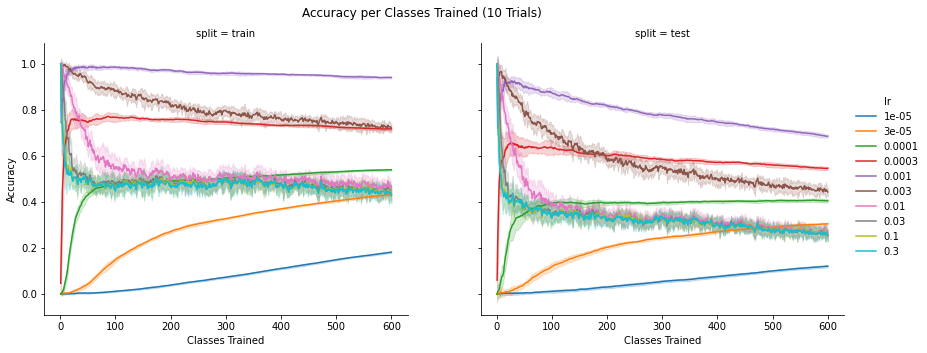

In [8]:
%%time

import warnings

# We want to plot the result across different choices of hyperparams.
def plot_perf_trajectory(df):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["model", "dataset", "num_test_examples"])
    # Only add a second level of nesting if needed.
    style = None
    if df.index.get_level_values("num_train_examples").nunique() > 1:
        style = "num_train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="classes_trained",
            y="accuracy",
            col="split",
            hue="lr",
            style=style,
            palette="tab10",
            kind="line",
            ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            aspect=1.3,
            facet_kws=dict(gridspec_kws=dict(top=0.88))
        )
    # Adjust labels.
    ntrials = df.index.get_level_values("trial").nunique()
    fg.figure.suptitle(f"Accuracy per Classes Trained ({ntrials} Trials)")
    fg.set_axis_labels("Classes Trained", "Accuracy")


# First we need to combine train/test columns into a single column, for the convenience of using `sns.relplot()`.
overall_accuracy = over_all_classes.rename(columns={"train_acc": "train", "test_acc": "test"})
overall_accuracy = overall_accuracy.melt(var_name="split", value_name="accuracy", ignore_index=False)

# Now do the plotting.
plot_perf_trajectory(overall_accuracy)

Now, best learning rate per data point.

In [9]:
# First group the potential data for each data point separately. This consists of groups over all trials and all
# learning rates.
train_cfg_cols = ["model", "dataset", "num_train_examples", "num_test_examples", "classes_trained"]
train_cfg_groups = over_all_classes.groupby(train_cfg_cols)

def select_best_lr(train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    lr_perf = train_group.groupby("lr").mean()
    # Tells us which LR is the best.
    best_lr = lr_perf.iloc[lr_perf.loc[:, "test_acc"].argmax()].name
    # Grabs all trials corresponding to the best LR.
    rows = train_group.index.get_level_values("lr") == best_lr
    # We must remove all the columns that are already specified by the group, because otherwise .apply() is not smart
    # enough to remove them and they will be duplicated.
    return train_group.loc[rows].reset_index(level=train_cfg_cols, drop=True)

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
best_trials_per_point = train_cfg_groups.apply(select_best_lr)

Final accuracy on 600 classes: 68.5% (std: 0.6%)


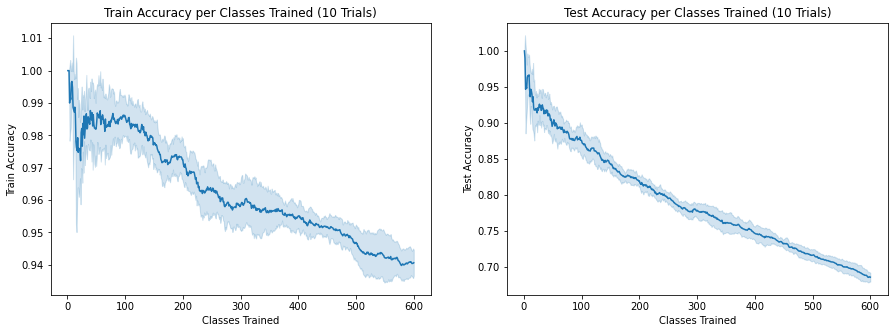

In [10]:
# Plot the results from the previous cell.
def plot_traj_per_lr(df, metric_name, colname, ax=None):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["model", "dataset", "num_test_examples"])
    # Only add another level of nesting if needed.
    style = None
    if df.index.get_level_values("num_train_examples").nunique() > 1:
        style = "num_train_examples"
    ax = sns.lineplot(
        data=df,
        x="classes_trained",
        y=colname,
        style=style,
        ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
        ax=ax,
    )
    ntrials = df.index.get_level_values("trial").nunique()
    ax.set_title(f"{metric_name} per Classes Trained ({ntrials} Trials)")
    ax.set_xlabel("Classes Trained")
    ax.set_ylabel(metric_name)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_traj_per_lr(best_trials_per_point, "Train Accuracy", "train_acc", ax=ax1)
plot_traj_per_lr(best_trials_per_point, "Test Accuracy", "test_acc", ax=ax2)

classes_trained = best_trials_per_point.index.get_level_values("classes_trained")
max_classes_test_acc = best_trials_per_point.loc[classes_trained == classes_trained.max(), "test_acc"]
print(f"Final accuracy on {classes_trained.max()} classes: "
      f"{max_classes_test_acc.mean():.1%} (std: {max_classes_test_acc.std():.1%})")

# Scratch Space

In [11]:
classes_trained = best_trials_per_point.index.get_level_values("classes_trained")
max_classes_rows = (classes_trained == classes_trained.max())
best_trials_per_point.loc[max_classes_rows, "test_acc"].mean()

0.6854333333333333